In [2]:
import os
import pathlib
import sqlite3
import sys
import ipywidgets as ipw
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import defaultdict
from math import ceil, sqrt
import numpy as np

from picocoder_client import GlitchResult
c: sqlite3.Cursor = None # type: ignore

MARKER = 's' # Square
color_mapper_half_succ_yellow = { # Go from 6 different markers/colors to 3 for better visibility once we have a lot of data
	GlitchResult.RESET					: 'y', # Yellow
	GlitchResult.NORMAL					: 'g', # Green
	GlitchResult.WEIRD					: 'y', # Yellow
	GlitchResult.SUCCESS				: 'r', # Red
	GlitchResult.HALF_SUCCESS			: 'y', # Yellow
	GlitchResult.BROKEN					: 'y', # Yellow
}
color_mapper_half_succ_red = { # Go from 6 different markers/colors to 3 for better visibility once we have a lot of data
	GlitchResult.RESET					: 'y', # Yellow
	GlitchResult.NORMAL					: 'g', # Green
	GlitchResult.WEIRD					: 'y', # Yellow
	GlitchResult.SUCCESS				: 'r', # Red
	GlitchResult.HALF_SUCCESS			: 'r', # Red
	GlitchResult.BROKEN					: 'y', # Yellow
}
COLOR_MAPPER = color_mapper_half_succ_red

def summarize(results, mapper: dict = COLOR_MAPPER):
	tot = len(results)
	replaced = [mapper[result] for result in results]
	yellow = replaced.count('y')
	green = replaced.count('g')
	red = replaced.count('r')
	print('Results:')
	print(f'  Total = {tot}')
	print(f'  Yellow = {yellow} - {yellow/tot*100:.2f}%')
	print(f'  Green = {green} - {green/tot*100:.2f}%')
	print(f'  Red = {red} - {red/tot*100:.2f}%')

def get_settings(table_name: str) -> tuple[str, str]:
	'''
	Returns the settings and extra description for the given table in a tuple
	'''
	# c.execute('SELECT settings FROM settings WHERE table_name = ?', (table_name,))
	# return c.fetchone()[0]
	c.execute('SELECT settings, extra FROM settings WHERE table_name = ?', (table_name,))
	return c.fetchone()

def list_tables():
	c.execute('SELECT table_name FROM settings')
	return [row[0] for row in c.fetchall() if row[0] != 'settings']

## Interactive plotter

In [3]:
w_db_path = ipw.Textarea(value='glitch2.db', description='DB path', layout=ipw.Layout(width='100%'))

def connect(db_path: str) -> None:
	global c
	conn = sqlite3.connect(f'file:{db_path}?mode=ro', uri=True)
	c = conn.cursor()
	print('Connected to DB')

# Create interactive widget to connect to the database
w_interact_factory = ipw.interactive.factory()
w_connect_interact_plot = w_interact_factory.options(manual=True, manual_name='Connect to DB')
out = w_connect_interact_plot(connect, db_path=w_db_path)
display(out)

interactive(children=(Textarea(value='glitch2.db', description='DB path', layout=Layout(width='100%')), Button…

<function __main__.connect(db_path: str) -> None>

In [ ]:
glitcher_options = ['ext_offset', 'prep_voltage', 'width', 'voltage', 'ext_offset+width']
w_xaxis = ipw.Dropdown(description='X axis', options=glitcher_options, value='width')
w_yaxis = ipw.Dropdown(description='Y axis', options=glitcher_options, value='voltage')
w_data_source_table = ipw.Dropdown(description='Source table', options=list_tables())
w_half_success_red = ipw.Checkbox(description='Plot half success in red', value=False)
w_ignore_normal = ipw.Checkbox(description='Ignore normal', value=False)
w_alpha = ipw.FloatSlider(
	value=0.05,
	min=0,
	max=1,
	step=0.05,
	description='Alpha',
	tooltip='Transparency of the markers (Successes are always fully opaque)',
)
w_png_export = ipw.Checkbox(description='PNG export', value=False, tooltip='Export to a PNG file (without title)')

def plot_graph(data_source_table: str, xaxis: str, yaxis: str, plot_half_success_red: bool, ignore_normal: bool, alpha: float, png_export: bool):
	mapper = color_mapper_half_succ_red if plot_half_success_red else color_mapper_half_succ_yellow
	def get_value(row, column):
		return sum([row[x] for x in column.split('+')])

	settings, extra_descr = get_settings(data_source_table)
	fig = plt.figure(layout="tight")
	ax = fig.add_subplot()
	if not png_export:
		fig.suptitle(f'{data_source_table}\n{settings}')
		fig.supxlabel(xaxis)
		fig.supylabel(yaxis)
	ax.xaxis.get_major_locator().set_params(integer=True)
	ax.yaxis.get_major_locator().set_params(integer=True)

	if ignore_normal:
		c.execute(f'SELECT * FROM {data_source_table} WHERE result != ?', (GlitchResult.NORMAL.name,))
	else:
		c.execute(f'SELECT * FROM {data_source_table}')
	columns = [ele for (ele, *_) in c.description]
	rows = c.fetchall()

	summarize([GlitchResult[result_name] for (_, _, _, _, result_name, *_) in rows], mapper)
	print(f'Extra description: {extra_descr if extra_descr else "None"}')

	# Prepare data for faster plotting
	xcoords = []
	xcoords_succ = []
	ycoords = []
	ycoords_succ = []
	colors = []
	colors_succ = []
	alphas = []
	alphas_succ = []
	for row in rows:
		row_dict = dict(zip(columns, row))
		result = GlitchResult[row_dict['result']]
		if result == GlitchResult.SUCCESS: # Plot successes last to make them visible
			xcoords_succ.append(get_value(row_dict, xaxis))
			ycoords_succ.append(get_value(row_dict, yaxis))
			color = mapper[result]
			colors_succ.append(color)
			alphas_succ.append(1)
		else:
			xcoords.append(get_value(row_dict, xaxis))
			ycoords.append(get_value(row_dict, yaxis))
			color = mapper[result]
			colors.append(color)
			alphas.append(alpha if color != 'r' else 1)
	xcoords.extend(xcoords_succ)
	ycoords.extend(ycoords_succ)
	colors.extend(colors_succ)
	alphas.extend(alphas_succ)
	print(f'Points plotted: {len(xcoords)}')
	ax.scatter(xcoords, ycoords, marker=MARKER, c=colors, alpha=alphas) # type: ignore # scatter() actually takes a list as alpha now

	if png_export:
		png_filename = f'{data_source_table}_{xaxis}_{yaxis}.png'
		print(f'Exporting to {png_filename}...')
		plt.savefig(png_filename, format='png', bbox_inches='tight', transparent=True, dpi=300)
	else:
		plt.show()

# Create interactive widget with button to trigger plot
w_interact_factory = ipw.interactive.factory()
w_hist_interact_plot = w_interact_factory.options(manual=True, manual_name='Plot')
out = w_hist_interact_plot(plot_graph, data_source_table=w_data_source_table, xaxis=w_xaxis, yaxis=w_yaxis, plot_half_success_red=w_half_success_red, ignore_normal=w_ignore_normal, alpha=w_alpha, png_export=w_png_export)
display(out)

interactive(children=(Dropdown(description='Source table', options=('_02a46ea_mul', '_02a46ea_mul_2', '_02a46e…

<function __main__.plot_graph(data_source_table: str, xaxis: str, yaxis: str, plot_half_success_red: bool, ignore_normal: bool, alpha: float, png_export: bool)>

## Successes histogram (reg test)

2233
Successes: 2233
Points plotted: 2077


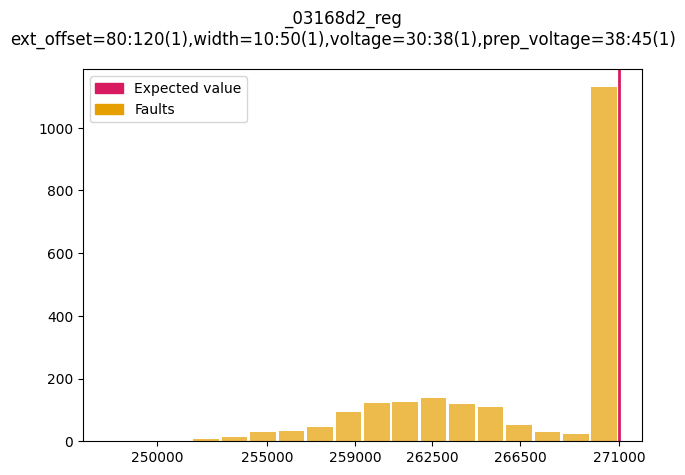

In [72]:
def plot_hist(data_source_table: str, png_export: bool):
	settings, extra_descr = get_settings(data_source_table)
	fig = plt.figure(layout="tight")
	ax = fig.add_subplot()
	if not png_export:
		fig.suptitle(f'{data_source_table}\n{settings}')
	ax.xaxis.get_major_locator().set_params(integer=True)
	ax.yaxis.get_major_locator().set_params(integer=True)

	c.execute(f'SELECT * FROM {data_source_table} WHERE result == ?', (GlitchResult.SUCCESS.name,))
	columns = [ele for (ele, *_) in c.description]
	rows = c.fetchall()
	print(len(rows))
	if 'summation' not in columns:
		print('No summation column found, run this on register tests')
		return

	success_values = []
	for row in rows:
		row_dict = dict(zip(columns, row))
		if 200000 < row_dict['summation'] < 300000: # Cut off the outliers
			success_values.append(row_dict['summation'])
	print(f'Successes: {len(rows)}')
	print(f'Points plotted: {len(success_values)}')

	ax.hist(success_values, bins='auto', color='#E69F00', alpha=0.7, rwidth=0.9)
	ax.axvline(x=271000, color='#D81B60', label='expected value', linewidth=2)
	plt.xticks([250000, 255000, 259000, 262500, 266500, 271000])

	# Add legend
	handles = [Rectangle((0,0),1,1,color='#D81B60'), Rectangle((0,0),1,1,color='#E69F00')]
	labels= ['Expected value', 'Faults']
	plt.legend(handles, labels)

	if png_export:
		png_filename = f'{data_source_table}_hist.png'
		print(f'Exporting to {png_filename}...')
		plt.savefig(png_filename, format='png', bbox_inches='tight', transparent=True, dpi=300)
	else:
		plt.show()

plot_hist('_03168d2_reg', False)

## Successes histogram (`cmp` test)

6824
Exporting to _5e872de_cmp_2_hist.png...


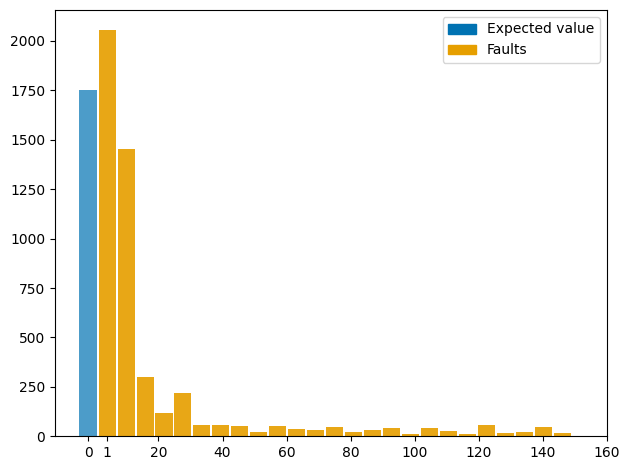

In [11]:
def plot_hist(data_source_table: str, png_export: bool):
	settings, extra_descr = get_settings(data_source_table)
	fig = plt.figure(layout="tight")
	ax = fig.add_subplot()
	if not png_export:
		fig.suptitle(f'{data_source_table}\n{settings}')
	ax.xaxis.get_major_locator().set_params(integer=True)
	ax.yaxis.get_major_locator().set_params(integer=True)

	c.execute(f'SELECT * FROM {data_source_table}')
	# c.execute(f'SELECT * FROM {data_source_table} WHERE result == ?', (GlitchResult.SUCCESS.name,))
	columns = [ele for (ele, *_) in c.description]
	rows = c.fetchall()
	print(len(rows))
	if 'fault_count' not in columns:
		print('No fault_count column found, run this on cmp tests')
		return

	success_values = []
	normal_values = []
	for row in rows:
		row_dict = dict(zip(columns, row))
		if row_dict['result'] == GlitchResult.SUCCESS.name:
			if row_dict['fault_count'] < 150: # Cut off the outliers
				success_values.append(row_dict['fault_count'])
		elif row_dict['result'] == GlitchResult.NORMAL.name:
			normal_values.append(row_dict['fault_count'])

	# Bin data
	h = ax.hist(success_values, bins=25, color='#E69F00', alpha=0.7, rwidth=0.9)

	# Add zero count for non-successes
	counts, bins, patches = h
	import numpy as np
	bins = np.insert(bins, 0, -5) # -5 to make the bar as wide as the other ones
	counts = np.insert(counts, 0, len(normal_values))
	h = ax.hist(bins[:-1], bins, weights=counts, color='#E69F00', alpha=0.7, rwidth=0.9)
	_, _, patches = h
	patches[0].set_fc('#0072B2') # Set zero bar color
	# Shift zero tick to the left and add 1 tick
	ticks = ax.get_xticks()
	ticks[0] = -2	# Replace -20 tick with -2, the position of our "0" tick mark
	ticks[1] = 4	# Replace 0 tick with 3, the position of our "1" tick mark
	ax.set_xticks(ticks)
	ax.set_xticklabels([0, 1] + [int(x) for x in ticks[2:]])

	# Add legend
	handles = [Rectangle((0,0),1,1,color='#0072B2'), Rectangle((0,0),1,1,color='#E69F00')]
	labels= ['Expected value', 'Faults']
	plt.legend(handles, labels)

	if png_export:
		png_filename = f'{data_source_table}_hist.png'
		print(f'Exporting to {png_filename}...')
		plt.savefig(png_filename, format='png', bbox_inches='tight', transparent=True, dpi=300)
	else:
		plt.show()

plot_hist('_5e872de_cmp_2', True)

## Successes histogram (add 10 test)

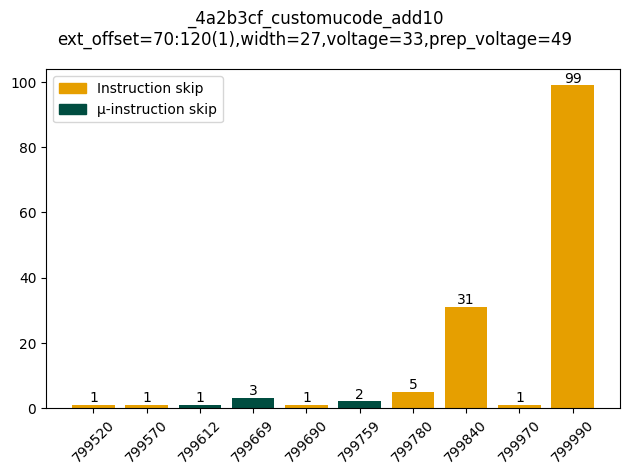

In [3]:
def plot_hist(data_source_table: str, png_export: bool):
	settings, extra_descr = get_settings(data_source_table)
	fig = plt.figure(layout="tight")
	ax = fig.add_subplot()
	if not png_export:
		fig.suptitle(f'{data_source_table}\n{settings}')
	ax.xaxis.get_major_locator().set_params(integer=True)
	ax.yaxis.get_major_locator().set_params(integer=True)

	c.execute(f'SELECT * FROM {data_source_table}')
	# c.execute(f'SELECT * FROM {data_source_table} WHERE result == ?', (GlitchResult.SUCCESS.name,))
	columns = [ele for (ele, *_) in c.description]
	rows = c.fetchall()
	if 'summation' not in columns:
		print('No summation column found, run this on cmp tests')
		return

	success_values = []
	for row in rows:
		row_dict = dict(zip(columns, row))
		if row_dict['result'] == GlitchResult.SUCCESS.name:
			if 700000 < row_dict['summation'] < 800000: # Cut off the outliers
				success_values.append(row_dict['summation'])

	# Bin data
	binned_successes = {i:success_values.count(i) for i in success_values}
	binned_successes_keys = sorted(binned_successes.keys())
	x_ticks = []	# The accumulated value
	pos = []		# Position of the bar on the x-axis
	vals = []		# The height of the bar
	colors = []		# The color of the bar
	for i, key in enumerate(binned_successes_keys):
		item = binned_successes[key]
		x_ticks.append(key)
		pos.append(i)
		vals.append(item)
		colors.append('#E69F00' if key % 10 == 0 else '#004D40')
	plt.bar(pos, vals, color=colors)

	# # Add expected value
	# ax.axvline(x=len(pos), color='#D81B60', label='expected value', linewidth=4)
	# pos.append(len(pos))
	# x_ticks.append(800000)

	ax.set_xticks(pos)							# Set a ticks at each bar
	ax.set_xticklabels(x_ticks, rotation=45)	# Set the tick labels with the actual values
	ax.bar_label(ax.containers[0])				# Add the count to the bars

	# Add legend
	handles = [Rectangle((0,0),1,1,color='#E69F00'), Rectangle((0,0),1,1,color='#004D40')]
	# handles = [Rectangle((0,0),1,1,color='#E69F00'), Rectangle((0,0),1,1,color='#004D40'), Rectangle((0,0),1,1,color='#D81B60')]
	labels= ['Instruction skip', 'μ-instruction skip']
	# labels= ['Instruction skip', 'μ-instruction skip', 'Expected value']
	plt.legend(handles, labels)

	if png_export:
		png_filename = f'{data_source_table}_hist.png'
		print(f'Exporting to {png_filename}...')
		plt.savefig(png_filename, format='png', bbox_inches='tight', transparent=True, dpi=300)
	else:
		plt.show()

plot_hist('_4a2b3cf_customucode_add10', True)

## Success histogram (RSA public modulus test)

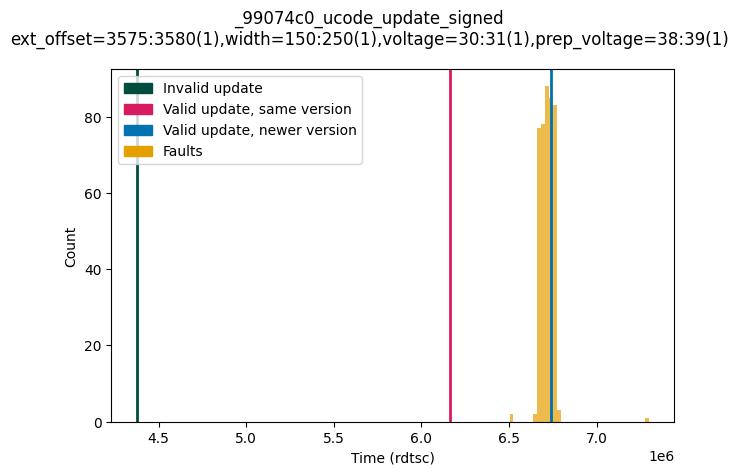

In [ ]:
%matplotlib inline
def plot_hist_rsa_modulus(data_source_table: str, png_export: bool):
	settings, extra_descr = get_settings(data_source_table)
	fig = plt.figure(layout="tight")
	ax = fig.add_subplot()
	if not png_export:
		fig.suptitle(f'{data_source_table}\n{settings}')
	ax.set_xlabel('Time (rdtsc)')
	ax.xaxis.get_major_locator().set_params(integer=True)
	ax.set_ylabel('Count')
	ax.yaxis.get_major_locator().set_params(integer=True)

	c.execute(f'SELECT * FROM {data_source_table} WHERE result == ?', (GlitchResult.SUCCESS.name,))
	columns = [ele for (ele, *_) in c.description]
	rows = c.fetchall()
	if 'time' not in columns:
		print('No time column found, run this on rsa modulus tests')
		return

	times = []
	for row in rows:
		row_dict = dict(zip(columns, row))
		if row_dict['time'] < 70000000: # Remove outliers
			times.append(row_dict['time'])

	h = ax.hist(times, bins=35, color='#E69F00', alpha=0.7, rwidth=0.9)
	ax.axvline(x=4375591, color='#004D40', label='Invalid update', linewidth=2)
	ax.axvline(x=6160509, color='#D81B60', label='Valid update, same version', linewidth=2)
	ax.axvline(x=6740000, color='#0072B2', label='Valid update, newer version', linewidth=2)

	# Add legend
	handles, labels = ax.get_legend_handles_labels()
	handles = [Rectangle((0,0),1,1,color=h.get_markerfacecolor()) for h in handles] # Make the legend markers rectangles
	handles.append(Rectangle((0,0),1,1,color='#E69F00'))
	labels.append('Faults')
	ax.legend(handles, labels)

	if png_export:
		png_filename = f'{data_source_table}_hist.png'
		print(f'Exporting to {png_filename}...')
		plt.savefig(png_filename, format='png', bbox_inches='tight', transparent=True, dpi=300)
	else:
		plt.show()

# plot_hist_rsa_modulus('_99074c0_ucode_update_signed', False)
# plot_hist_rsa_modulus('_90ec1b5_ucode_update_reencrypt', False)
plot_hist_rsa_modulus('_8Gb_86ab61e_rsamod_2', False)

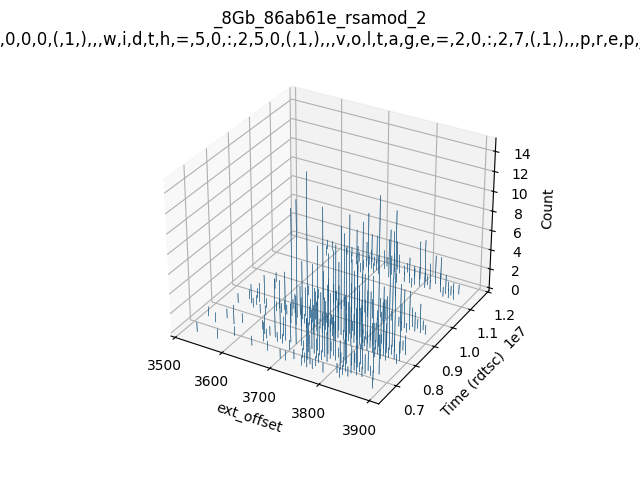

In [ ]:
# %matplotlib ipympl
# Make it 3D

def plot_hist_rsa_modulus_3d(data_source_table: str, png_export: bool):
	settings, extra_descr = get_settings(data_source_table)
	fig3d = plt.figure()
	fig3d.suptitle(f'{data_source_table}\n{','.join(settings)}')
	ax3d = fig3d.add_subplot(projection='3d')
	ax3d.set_xlabel('ext_offset')
	ax3d.xaxis.get_major_locator().set_params(integer=True)
	ax3d.set_ylabel('Time (rdtsc)')
	ax3d.yaxis.get_major_locator().set_params(integer=True)
	ax3d.set_zlabel('Count')
	ax3d.zaxis.get_major_locator().set_params(integer=True)

	c.execute(f'SELECT * FROM {data_source_table} WHERE result == ?', (GlitchResult.SUCCESS.name,))

	columns = [ele for (ele, *_) in c.description]
	rows = c.fetchall()
	if 'time' not in columns:
		print('No time column found, run this on rsa modulus tests')
		return

	data: tuple[list[int], list[int]] = ([], []) # (ext_offset, time)
	for row in rows:
		row_dict = dict(zip(columns, row))
		if row_dict['time'] < 70000000: # Remove outliers
			data[0].append(row_dict['ext_offset'])
			data[1].append(row_dict['time'])

	hist, xedges, yedges = np.histogram2d(*data, bins=35)

	# Construct arrays for the anchor positions of the bars.
	xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
	xpos = xpos.ravel()
	ypos = ypos.ravel()
	zpos = 0

	# Construct arrays with the dimensions for the bars.
	dx = dy = np.ones_like(zpos)
	dz = hist.ravel()

	ax3d.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plot_hist_rsa_modulus_3d('_8Gb_86ab61e_rsamod_2', False)


## An axis per $V_f$ value

In [3]:
TABLE = '_0d0af5f_customucode_6'
XAXIS = 'width'
YAXIS = 'ext_offset'
settings = get_settings(TABLE).split(',')
print('Settings:')
print('  ' + '\n  '.join(settings))

c.execute(f'SELECT DISTINCT voltage FROM {TABLE}')
voltages = [v for (v,) in c.fetchall()]
voltages.sort()

col_num = ceil(sqrt(len(voltages)))
row_num = ceil(len(voltages) / col_num)

fig = plt.figure(layout="tight")
fig.suptitle(f'{TABLE}\n{','.join(settings)}')
axs = {}
for i, voltage in enumerate(voltages):
	axs[voltage] = fig.add_subplot(row_num, col_num, i+1)
	axs[voltage].set_title(f'$V_f$ {voltage}')
	fig.supxlabel(XAXIS)
	fig.supylabel(YAXIS)

c.execute(f'SELECT * FROM {TABLE}')
columns = [ele for (ele, *_) in c.description]
rows = c.fetchall()

summarize([GlitchResult[result_name] for (_, _, _, _, result_name, *_) in rows])

# Prepare data for faster plotting
xcoords = defaultdict(list)
ycoords = defaultdict(list)
colors = defaultdict(list)
alphas = defaultdict(list)
for row in rows:
	row_dict = dict(zip(columns, row))
	xcoords[row_dict['voltage']].append(row_dict[XAXIS])
	ycoords[row_dict['voltage']].append(row_dict[YAXIS])
	result = GlitchResult[row_dict['result']]
	color = COLOR_MAPPER[result]
	colors[row_dict['voltage']].append(color)
	alphas[row_dict['voltage']].append(0.05 if color != 'r' else 1)

for voltage in voltages:
	axs[voltage].scatter(xcoords[voltage], ycoords[voltage], marker=MARKER, c=colors[voltage], alpha=alphas[voltage])

AttributeError: 'tuple' object has no attribute 'split'

## One plot per Vp

Prep voltage 34
Results:
  Total = 19951
  Yellow = 12478 - 62.54%
  Green = 7469 - 37.44%
  Red = 4 - 0.02%
Prep voltage 35
Results:
  Total = 20130
  Yellow = 13118 - 65.17%
  Green = 7009 - 34.82%
  Red = 3 - 0.01%
Prep voltage 36
Results:
  Total = 20075
  Yellow = 13361 - 66.56%
  Green = 6707 - 33.41%
  Red = 7 - 0.03%


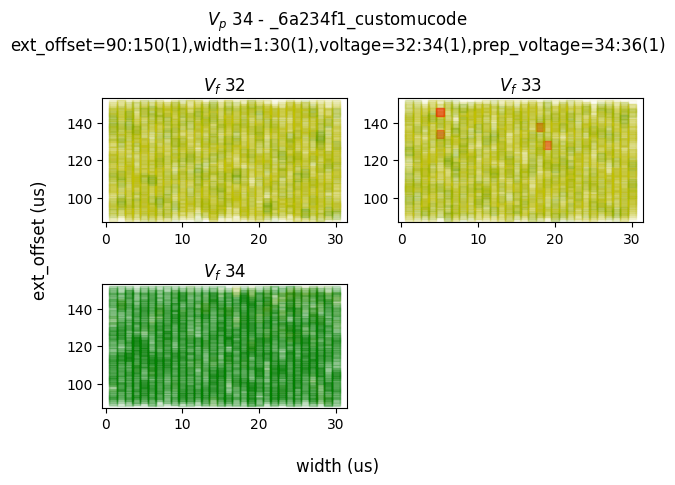

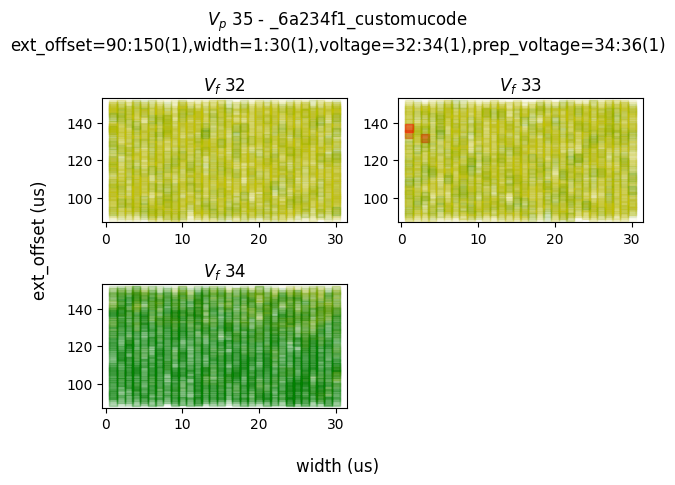

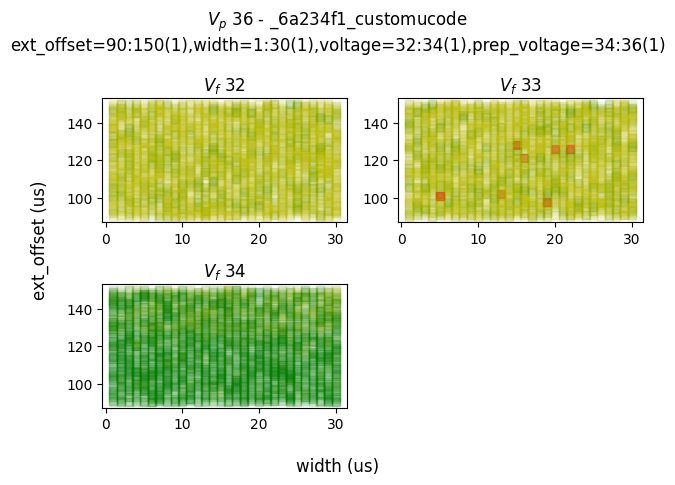

In [3]:
XAXIS = 'width'
YAXIS = 'ext_offset'
settings = get_settings(TABLE).split(',')
print('Settings:')
print('  ' + '\n  '.join(settings))

c.execute(f'SELECT DISTINCT voltage FROM {TABLE}')
voltages = [v for (v,) in c.fetchall()]
voltages.sort()
col_num = ceil(sqrt(len(voltages)))
row_num = ceil(len(voltages) / col_num)

c.execute(f'SELECT DISTINCT prep_voltage FROM {TABLE}')
prep_voltages = [v for (v,) in c.fetchall()]
prep_voltages.sort()

figs = {}
for v_p in prep_voltages:
	figs[v_p] = plt.figure(layout="tight")
	figs[v_p].suptitle(f'$V_p$ {v_p} - {TABLE}\n{','.join(settings)}')
	axs = {}
	for i, voltage in enumerate(voltages):
		axs[voltage] = figs[v_p].add_subplot(row_num, col_num, i+1)
		axs[voltage].set_title(f'$V_f$ {voltage}')
		figs[v_p].supxlabel('width (us)')
		figs[v_p].supylabel("ext_offset (us)")

	c.execute(f'SELECT * FROM {TABLE} WHERE prep_voltage = {v_p}')
	rows = c.fetchall()

	print(f'Prep voltage {v_p}')
	summarize([GlitchResult[result_name] for (_, _, _, _, result_name, _, _, _, _) in rows])

	for i, row in enumerate(rows):
		[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
		result = GlitchResult[result_name]

		# # if result in [GlitchResult.NORMAL, GlitchResult.SUCCESS, GlitchResult.HALF_SUCCESS]:
		# if result == GlitchResult.NORMAL:
		# 	continue
		marker = COLOR_MAPPER[result]
		alpha = 0.05 if marker != 'sr' else 0.5
		axs[voltage].plot(width, ext_offset, marker, alpha=alpha)
	
plt.show()

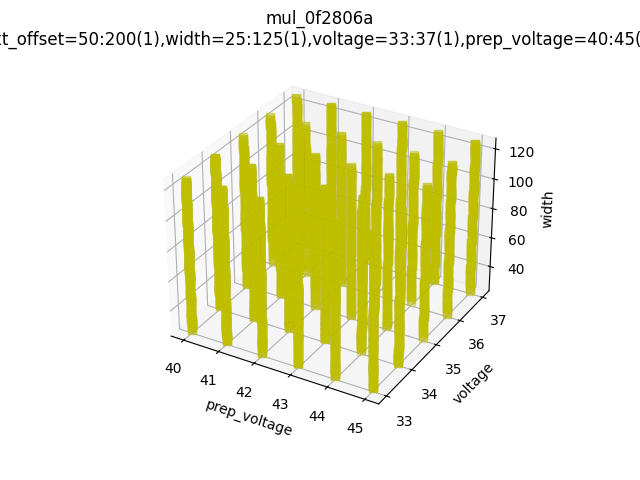

No such comm: 94dd1dfea5744794b0c2f1a7ae17b871


In [21]:
%matplotlib widget

fig3d = plt.figure()
fig3d.suptitle(f'{TABLE}\n{','.join(settings)}')
ax3d = fig3d.add_subplot(projection='3d')
ax3d.set_xlabel('prep_voltage')
ax3d.set_ylabel('voltage')
ax3d.set_zlabel('width')

for i, row in enumerate(rows):
	[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
	result = GlitchResult[result_name]

	if result == GlitchResult.NORMAL:
		continue
	ax3d.plot(prep_voltage, voltage, width, COLOR_MAPPER[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)

SUCCESS at 36->33
SUCCESS at 36->33
SUCCESS at 36->33
SUCCESS at 36->33
SUCCESS at 36->33
SUCCESS at 36->33
SUCCESS at 36->33


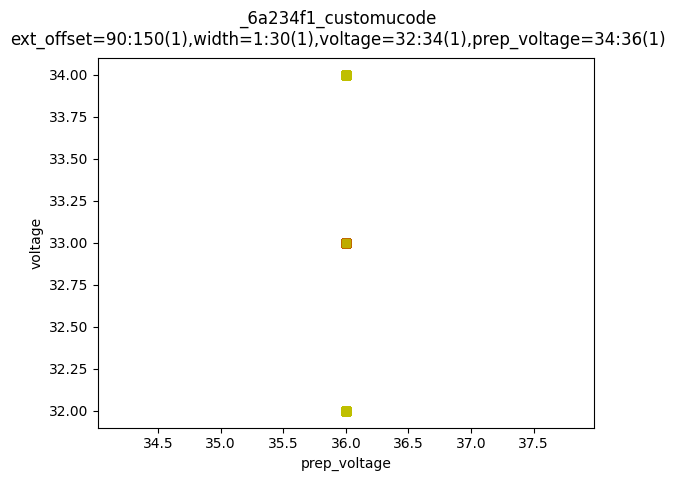

In [4]:
%matplotlib inline
fig_vp_vf, ax_vp_vf = plt.subplots()
fig_vp_vf.suptitle(f'{TABLE}\n{','.join(settings)}')
ax_vp_vf.set_xlabel('prep_voltage')
ax_vp_vf.set_ylabel('voltage')

for i, row in enumerate(rows):
	[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
	result = GlitchResult[result_name]

	# if result in [GlitchResult.NORMAL, GlitchResult.SUCCESS, GlitchResult.HALF_SUCCESS]:
	if result == GlitchResult.NORMAL:
		continue
	marker = COLOR_MAPPER[result]
	alpha = 0.05 if marker != 'sr' else 1
	ax_vp_vf.plot(prep_voltage, voltage, marker, alpha=alpha)

	if result in [GlitchResult.HALF_SUCCESS, GlitchResult.SUCCESS]:
		print(f'{result_name} at {prep_voltage}->{voltage}')

## Plotting only half success and success

In [ ]:
%matplotlib inline

col_num = ceil(sqrt(len(voltages)))
row_num = ceil(len(voltages) / col_num)

fig = plt.figure(layout="tight")
axs = {}
for i, voltage in enumerate(voltages):
	axs[voltage] = fig.add_subplot(row_num, col_num, i+1)
	axs[voltage].set_title(f'VID {voltage}')

for i, row in enumerate(rows):
	[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
	result = GlitchResult[result_name]

	# if result in [GlitchResult.NORMAL, GlitchResult.SUCCESS, GlitchResult.HALF_SUCCESS]:
	if result == GlitchResult.HALF_SUCCESS:
		axs[voltage].plot(width, ext_offset, 'sy', alpha=0.1)
	elif result == GlitchResult.SUCCESS:
		axs[voltage].plot(width, ext_offset, 'sr', alpha=0.5)

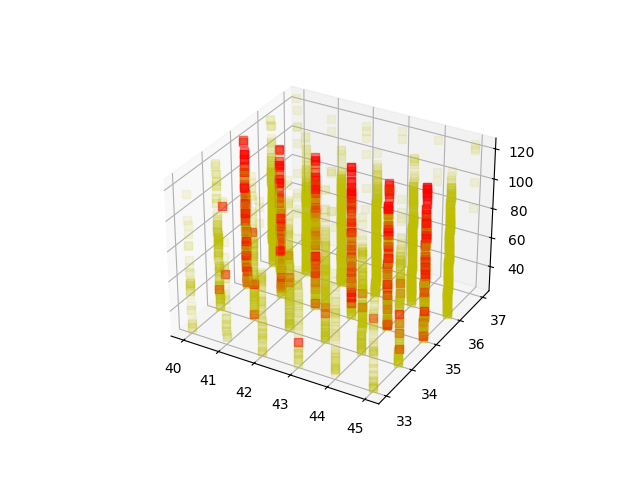

In [20]:
%matplotlib widget

fig3d = plt.figure()
ax3d = fig3d.add_subplot(projection='3d')

for i, row in enumerate(rows):
	[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
	result = GlitchResult[result_name]

	if result == GlitchResult.HALF_SUCCESS:
		ax3d.plot(prep_voltage, voltage, width, 'sy', alpha=0.1)
	elif result == GlitchResult.SUCCESS:
		ax3d.plot(prep_voltage, voltage, width, 'sr', alpha=0.5)

In [ ]:
%matplotlib inline
fig_vp_vf, ax_vp_vf = plt.subplots()

for i, row in enumerate(rows):
	result = GlitchResult[result_name]

	# if result in [GlitchResult.NORMAL, GlitchResult.SUCCESS, GlitchResult.HALF_SUCCESS]:
	if result == GlitchResult.HALF_SUCCESS:
		ax_vp_vf.plot(prep_voltage, voltage, 'sy', alpha=0.1)
	elif result == GlitchResult.SUCCESS:
		ax_vp_vf.plot(prep_voltage, voltage, 'sr', alpha=0.5)

Fix Vf to 35 (other values are less interesting) and plot a 2D grapgh with Vp and width

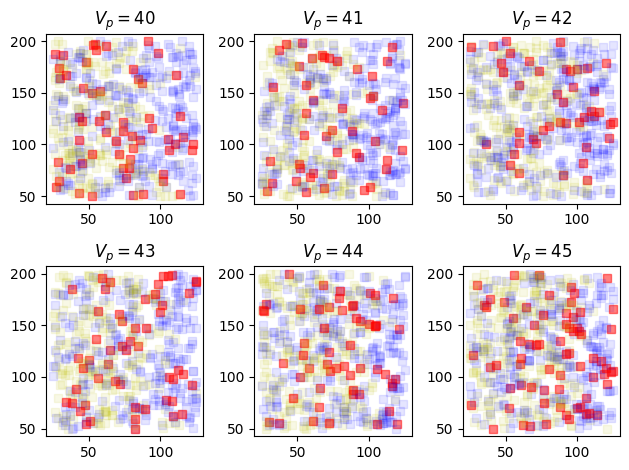

In [24]:
%matplotlib inline

c.execute(f'SELECT * FROM {TABLE} WHERE voltage = 35')
rows_vp_35 = c.fetchall()

c.execute(f'SELECT DISTINCT prep_voltage FROM {TABLE}')
prep_voltages = [v for (v,) in c.fetchall()]
prep_voltages.sort()

col_num = ceil(sqrt(len(prep_voltages)))
row_num = ceil(len(prep_voltages) / col_num)

fig_vp = plt.figure(layout="tight")
axs_vp = {}
for i, prep_voltage in enumerate(prep_voltages):
	axs_vp[prep_voltage] = fig_vp.add_subplot(row_num, col_num, i+1)
	axs_vp[prep_voltage].set_title(f'$V_p = {prep_voltage}$')

for i, row in enumerate(rows_vp_35):
	[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
	result = GlitchResult[result_name]

	# if result in [GlitchResult.NORMAL, GlitchResult.SUCCESS, GlitchResult.HALF_SUCCESS]:
	if result == GlitchResult.HALF_SUCCESS:
		axs_vp[prep_voltage].plot(width, ext_offset, 'sy', alpha=0.1)
	elif result == GlitchResult.SUCCESS:
		axs_vp[prep_voltage].plot(width, ext_offset, 'sr', alpha=0.5)
	elif result in [GlitchResult.BROKEN, GlitchResult.RESET]:
		axs_vp[prep_voltage].plot(width, ext_offset, 'sb', alpha=0.1)